In [40]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import arviz as az

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import hpdi
from numpyro.infer import MCMC, NUTS, Predictive


#matplotlib.use("agg")
az.style.use("arviz-darkgrid")
N_POINTS_PER_UNIT = 10  # number of points to plot for each unit interval
numpyro.set_host_device_count(4)

%matplotlib inline

## Static implementation

In [64]:
rng = np.random.default_rng(32167)

In [211]:
from statsmodels.tsa.arima_process import ArmaProcess

# Generate simulated data with known ARIMA parameters
ar_coefs = np.array([-.5, -0.2])
ma_coefs = np.array([0.3])


original = {"ma": ma_coefs, "ar": ar_coefs}
arma_process = ArmaProcess(ar_coefs, ma_coefs)
simulated_data = arima_process.generate_sample(nsample=100, distrvs=rng.standard_normal)
y = y_train = simulated_data

print(f"ar_coefs: {ar_coefs}")
print(f"ma_coefs: {ma_coefs}")
print(f"simulated: {simulated_data}")

ar_coefs: [-0.5 -0.2]
ma_coefs: [0.3]
simulated: [ 6.56089791e-01 -4.06043706e-01 -3.24881830e-01 -2.34339160e-01
 -3.52455996e-01 -6.19373335e-02 -5.47955547e-01 -2.16099626e+00
 -1.33762014e+00 -8.48340412e-01 -1.23034339e+00 -3.36002198e-01
 -1.11653745e-01  2.20936228e-01  1.48621915e+00  1.44332907e+00
 -1.40958936e-01 -2.02904882e-01  2.96545083e-01  4.22397913e-01
 -4.02868532e-01  6.18743673e-01  8.20863281e-01 -2.36877324e-01
  7.18246313e-01  5.58770862e-01  7.37482242e-01  7.17091966e-01
  1.27320403e+00 -6.78728114e-01 -2.14613706e+00 -5.84292864e-01
  2.72707826e-01  1.45611799e-01 -7.66520382e-01  4.61108983e-01
 -3.55471492e-01  1.09559248e-01 -7.20492348e-01 -1.37741357e+00
 -1.07780352e+00 -1.75982835e-01  1.31072413e+00  7.68168113e-01
  3.52565820e-01  2.04653799e+00  1.48775144e-01  4.83235757e-01
  5.90303531e-01  2.25137128e-01 -1.65729512e-01 -6.77253022e-01
 -4.01191465e-01 -1.57522602e-01  6.59056371e-02 -3.55265304e-02
 -3.75534804e-01 -4.70235376e-02  1.00005

In [212]:
arma_process.isstationary

True

Text(0.5, 1.0, 'Original simulated data')

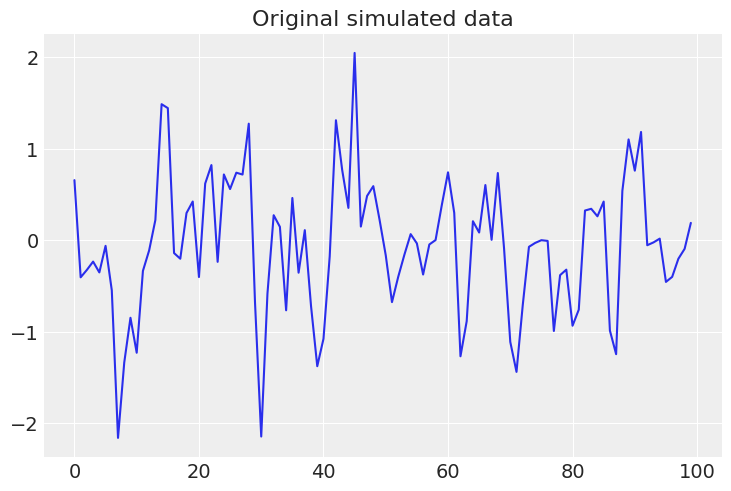

In [213]:
plt.plot(y)
plt.title("Original simulated data")

In [214]:
import numpy as np
from scipy.optimize import minimize


def arima(data, p, d, q):
    """
    Implements the ARIMA model on a time series using numpy and scipy.
    
    Parameters:
    - data: a 1-dimensional numpy array containing the time series data
    - p: the autoregressive (AR) order
    - d: the differencing order
    - q: the moving average (MA) order
    
    Returns:
    - predictions: a numpy array containing the forecasted values for the time series
    """
    
    # Define a function to calculate the residual sum of squares (RSS) for a given set of ARIMA coefficients
    def rss(params):
        ar_params = params[:p]
        ma_params = params[p:]
        y_hat = np.zeros_like(data)
        y_hat[:p] = data[:p]
        for i in range(p, len(data)):
            ar_term = np.sum(ar_params * y_hat[i-p:i])
            ma_term = np.sum(ma_params * (data[i-q:i] - y_hat[i-q:i]))
            y_hat[i] = ar_term + ma_term
        residuals = data - y_hat
        return np.sum(residuals**2)
    
    # Initialize ARIMA coefficients
    ar_coefs = np.ones(p)
    ma_coefs = np.ones(q)
    initial_guess = np.concatenate([ar_coefs, ma_coefs])
    
    # Minimize RSS to estimate coefficients
    result = minimize(rss, initial_guess, method='BFGS')
    ar_coefs = result.x[:p]
    ma_coefs = result.x[p:]
    
    # Apply the ARIMA model to the time series
    y_hat = np.zeros_like(data)
    y_hat[:p] = data[:p]
    for i in range(p, len(data)):
        ar_term = np.sum(ar_coefs * y_hat[i-p:i])
        ma_term = np.sum(ma_coefs * (data[i-q:i] - y_hat[i-q:i]))
        y_hat[i] = ar_term + ma_term
    
    # Apply differencing if necessary
    if d > 0:
        y_hat = np.cumsum(y_hat)
        y_hat = np.insert(y_hat, 0, data[0])
        y_hat = y_hat[:-d] - y_hat[d:]
    
    coefs = {"ar": ar_coefs, "ma": ma_coefs}
    return y_hat, coefs

# Test the ARIMA function on sample data
# data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# data = np.random.randint(100, size=100)
data = y
predictions, coefs = arima(data, p=2, d=0, q=1)
print(f"Expected: {original}")
print(f"Got: {coefs}")
print("Predictions: ", predictions)

Expected: {'ma': array([0.3]), 'ar': array([-0.5, -0.2])}
Got: {'ar': array([0.06723097, 0.14941786]), 'ma': array([0.59092604])}
Predictions:  [ 0.65608979 -0.40604371 -0.01656063 -0.21196819 -0.04600481 -0.20221475
  0.04958614 -0.35928898 -1.11502621 -0.32229673 -0.43397409 -0.55710716
  0.01823842 -0.11148637  0.1810053   0.79083494  0.5159098  -0.2579061
  0.02865099  0.14524729  0.18740429 -0.31104092  0.51555823  0.23653473
 -0.20974752  0.53293815  0.08079417  0.43595612  0.23670199  0.6771733
 -0.68414196 -0.92062699  0.01519495  0.09254682  0.0462072  -0.4671357
  0.48183209 -0.45419615  0.29766676 -0.58771604 -0.53445568 -0.44044833
  0.05453673  0.72085084  0.13933556  0.19528603  1.13249987 -0.39896358
  0.53784133  0.08454168  0.13187314 -0.15047314 -0.32490537 -0.10374256
 -0.06912472  0.06248977 -0.05323062 -0.19421029  0.05437925 -0.03647487
  0.2458814   0.32730084  0.04790197 -0.74901709 -0.18962227  0.15570423
 -0.03215473  0.3806354  -0.16791385  0.53343843 -0.2996

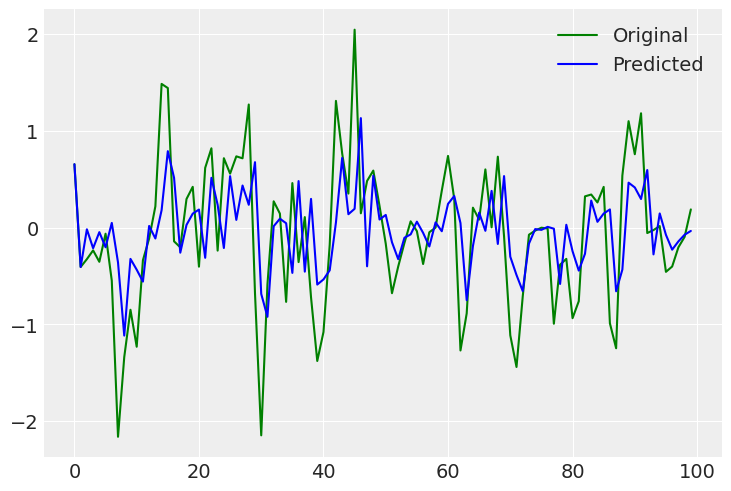

In [215]:
plt.plot(y, 'g')
plt.plot(predictions, 'b')
plt.legend(['Original', 'Predicted'])

# Model

## Definition

In [220]:
def arma(y, p, q, future=0, key=99):
    T = len(y)
    noise = numpyro.sample("noise", dist.HalfNormal(1))
#     mu = numpyro.sample("mu", dist.Normal(0, 1))
    mu = 0
    eps_dist = dist.Normal(0, 1)
    
    key = jax.random.PRNGKey(key)
    
    with numpyro.plate("p_size", p):
        phi = numpyro.sample("ar_coef", dist.Normal(0, 1))
    with numpyro.plate("q_size", q):
        theta = numpyro.sample("ma_coef", dist.Normal(0, 1))

        
    def transition_fn(carry, t):
        y_p, y_q = carry
        ar_term = jnp.sum(y_p * phi)
        ma_term = jnp.sum(y_q * theta)
        
        y_mu = mu + ar_term + ma_term
        
        y_hat = numpyro.sample("y_hat", dist.Normal(y_mu, noise))

        y_p = y_p.at[:-1].set(y_p[1:])
        y_p = y_p.at[-1].set(y_hat)

        y_q = y_q.at[:-1].set(y_q[1:])
        y_q = y_q.at[-1].set(y_hat - y_mu)
        
        return (y_p, y_q), y_hat
    
    y_p = jnp.zeros(p)
    y_p = y[:len(y_p)]
    y_q = jnp.zeros(q)
    
    with numpyro.handlers.condition(data={"y_hat": y}):
        _, preds = scan(
            transition_fn,
            (y_p, y_q),
            jnp.arange(T + future),
        )

    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

In [221]:
y_train = jnp.array(y[:-5])

In [222]:
model = arma
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=200, num_samples=5000, num_chains=4)
mcmc.run(jax.random.PRNGKey(0), y_train, p=2, q=1)
mcmc.print_summary()
samples = mcmc.get_samples()

  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/5200 [00:00<?, ?it/s]

  0%|          | 0/5200 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
ar_coef[0]      0.08      0.18      0.09     -0.20      0.36   3007.98      1.00
ar_coef[1]      0.07      0.32      0.01     -0.41      0.54   2466.33      1.00
ma_coef[0]      0.48      0.32      0.56      0.03      0.91   2297.07      1.00
     noise      0.67      0.05      0.67      0.59      0.75   8846.06      1.00

Number of divergences: 354


In [223]:
original

{'ma': array([0.3]), 'ar': array([-0.5, -0.2])}

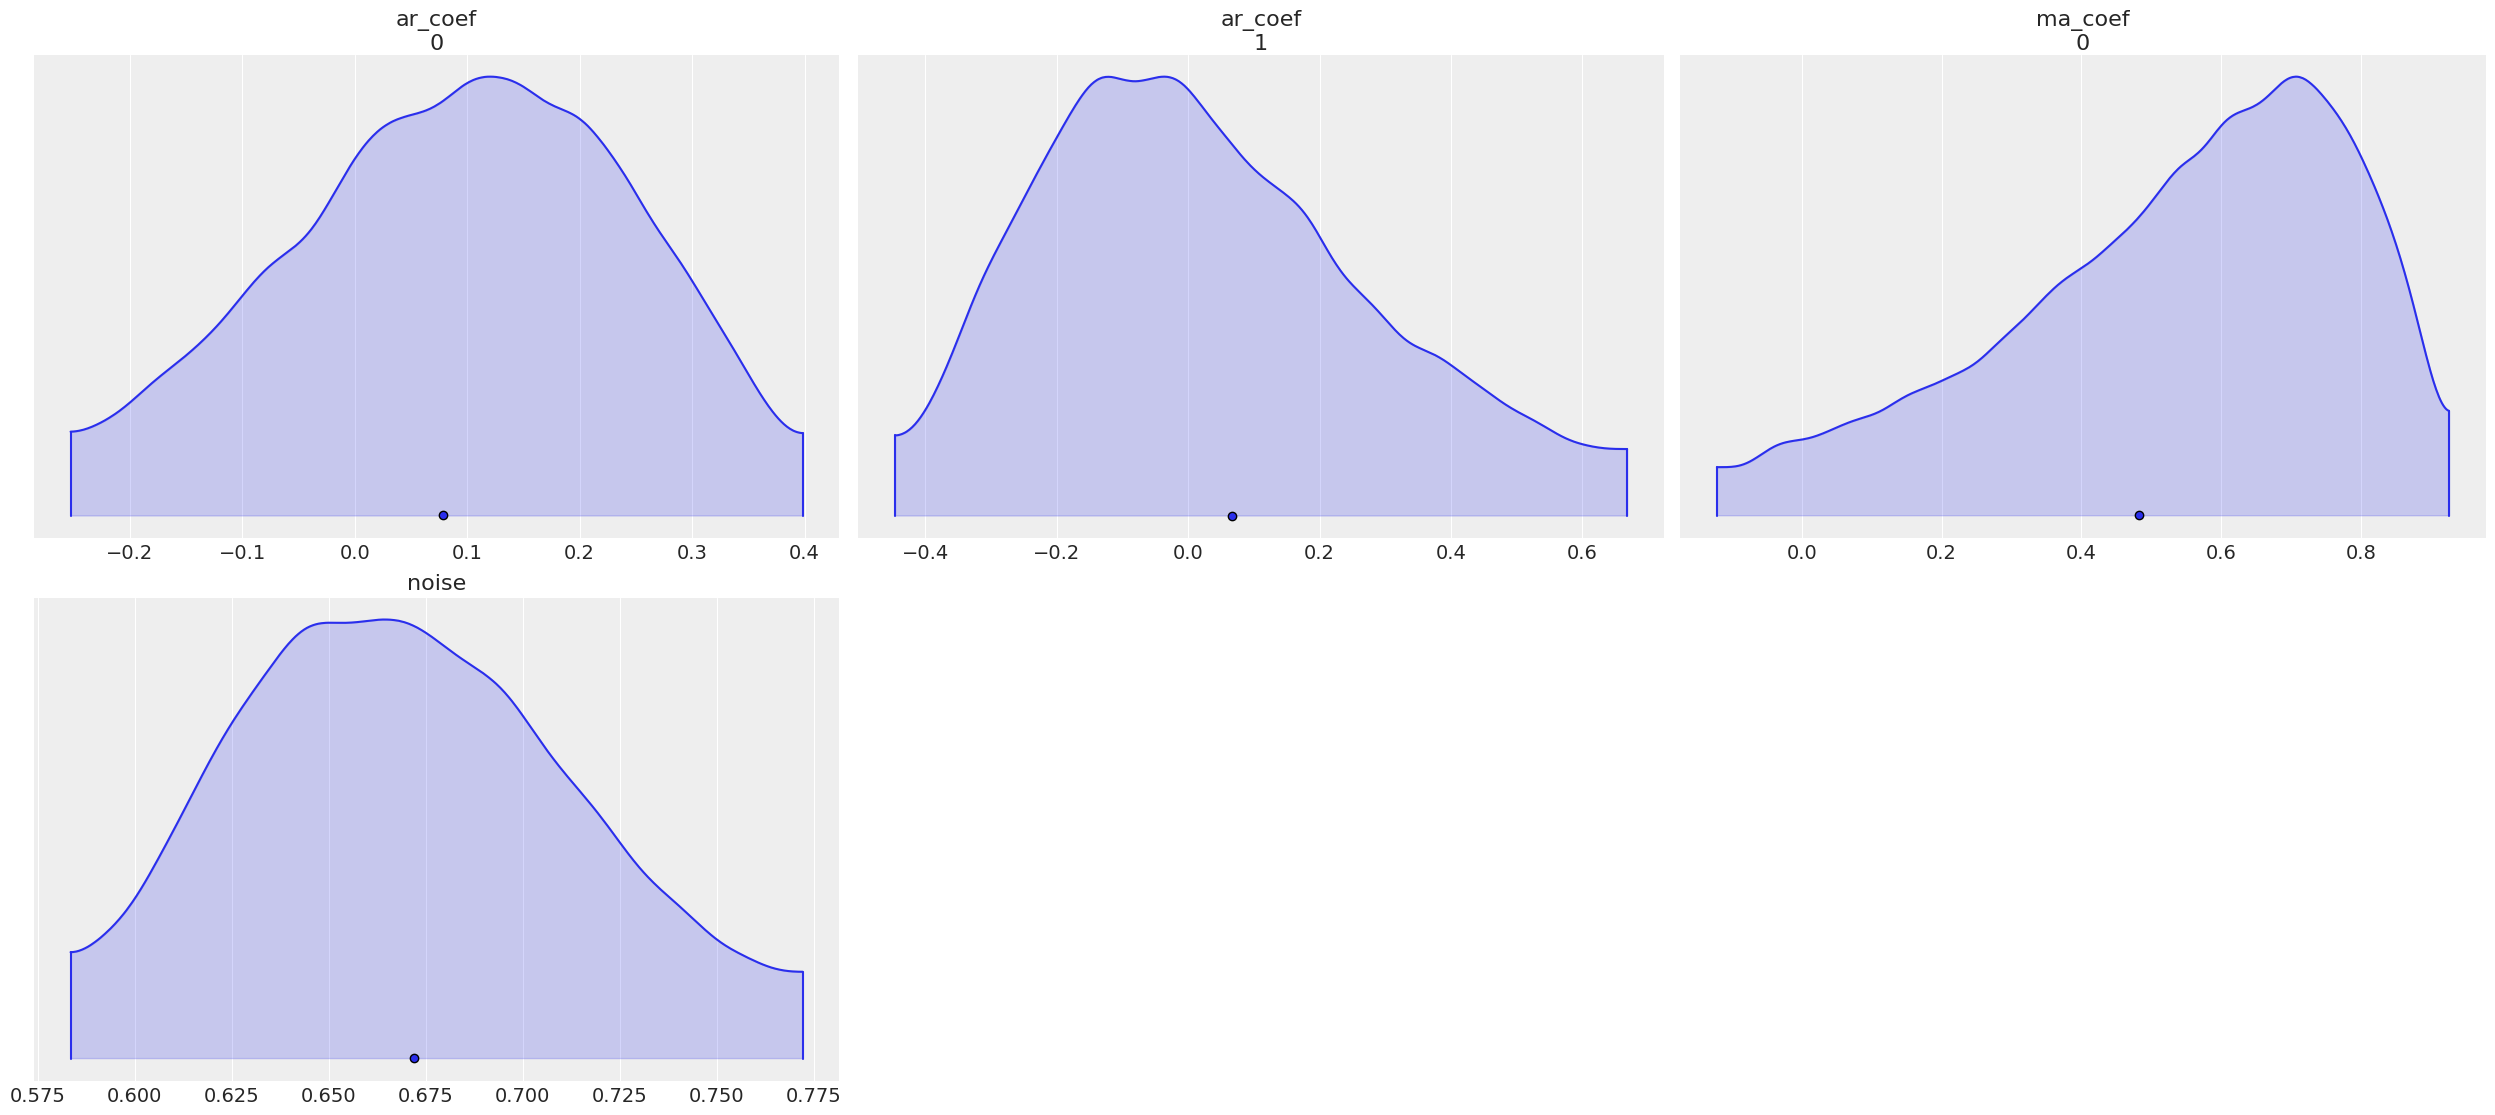

In [224]:
arma_post = az.from_numpyro(posterior=mcmc)

az.plot_density(
    [arma_post],
    shade=0.2,
)
plt.show()

array([[<Axes: title={'center': 'ar_coef'}>,
        <Axes: title={'center': 'ar_coef'}>],
       [<Axes: title={'center': 'ma_coef'}>,
        <Axes: title={'center': 'ma_coef'}>],
       [<Axes: title={'center': 'noise'}>,
        <Axes: title={'center': 'noise'}>]], dtype=object)

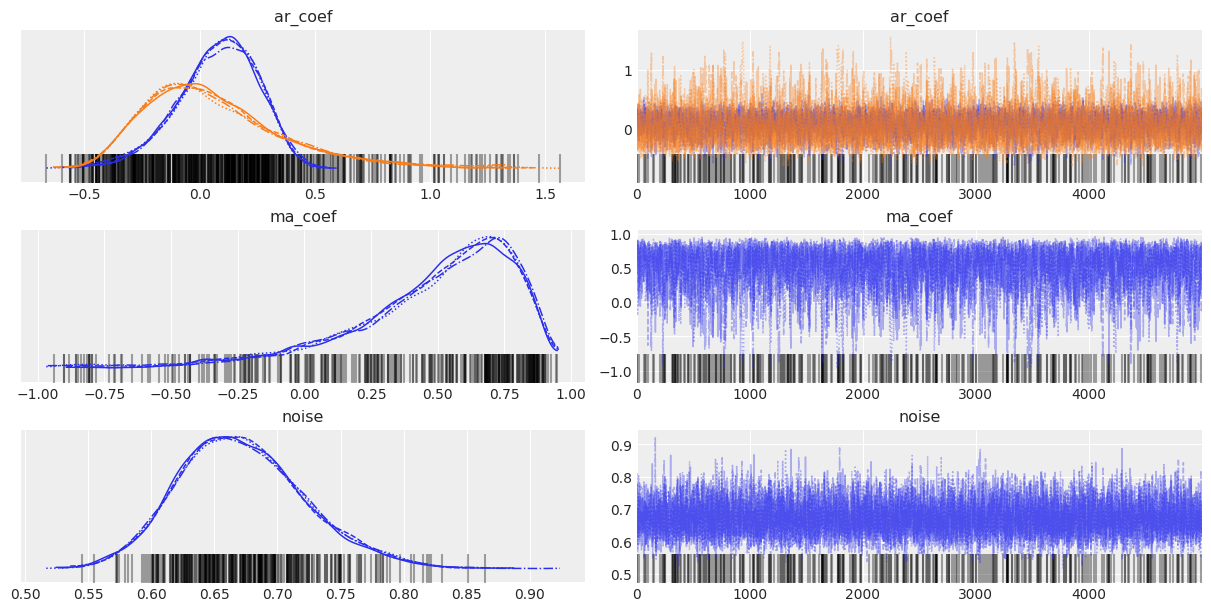

In [226]:
az.plot_trace(arma_post)

In [227]:
y_train = jnp.array(y)

In [244]:
future = 10
forecasts = {}
y_out = jnp.zeros_like(y_train)
y_out = y_train.at[:-future].set(y_train[:-future])

predict = Predictive(model, samples, return_sites=["y_forecast"])

for i in range(future):
    pred = predict(jax.random.PRNGKey(30), y_train[-20-future+i:-future+i], p=2, q=1, future=2)
    y_forecast = pred['y_forecast']
    y_out = y_out.at[-future+i].set(y_forecast.mean(axis=0)[0])
    forecasts[i] = y_forecast.mean(axis=0)

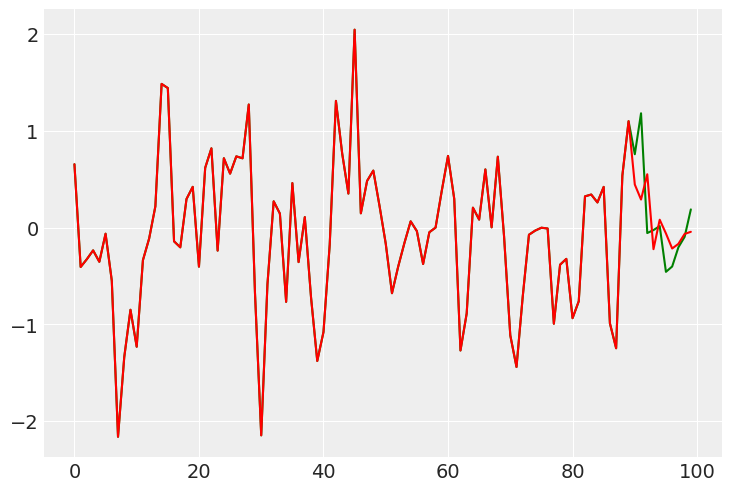

In [245]:
# plt.plot(y_pred.mean(axis=0), 'b')
plt.plot(y_train, 'g')
# plt.plot(np.arange(len(y_train) - future, len(y_train)), y_forecast.mean(axis=0), 'r')
plt.plot(y_out, 'r')

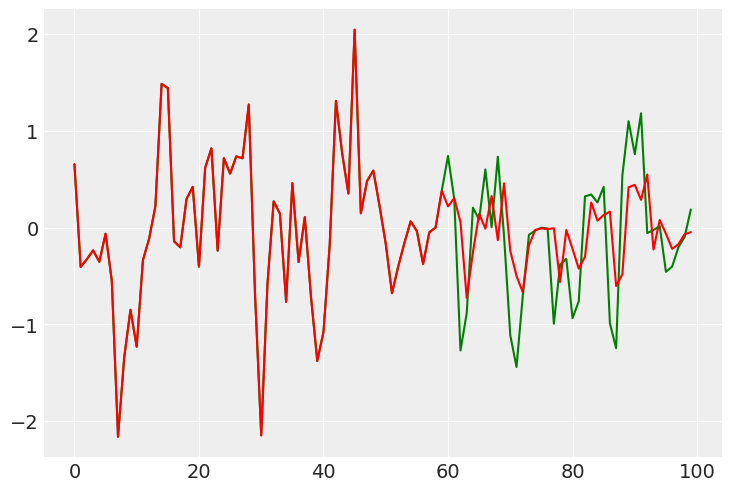

In [232]:
# plt.plot(y_pred.mean(axis=0), 'b')
plt.plot(y_train, 'g')
# plt.plot(np.arange(len(y_train) - future, len(y_train)), y_forecast.mean(axis=0), 'r')
plt.plot(y_out, 'r')

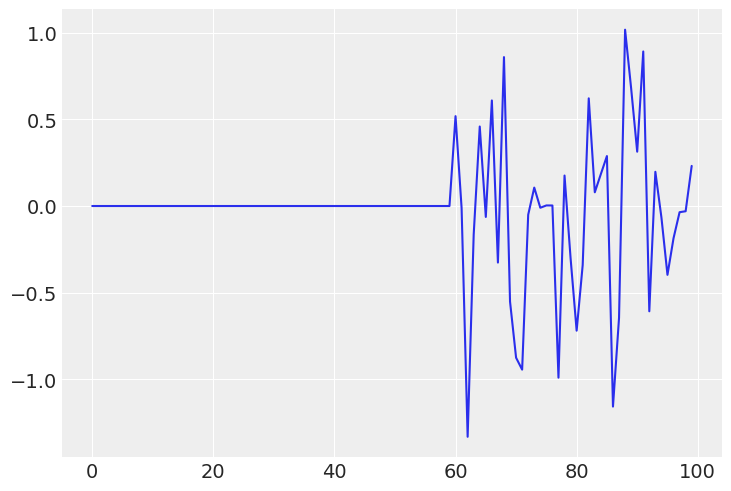

In [243]:
plt.plot(y_train - y_out)

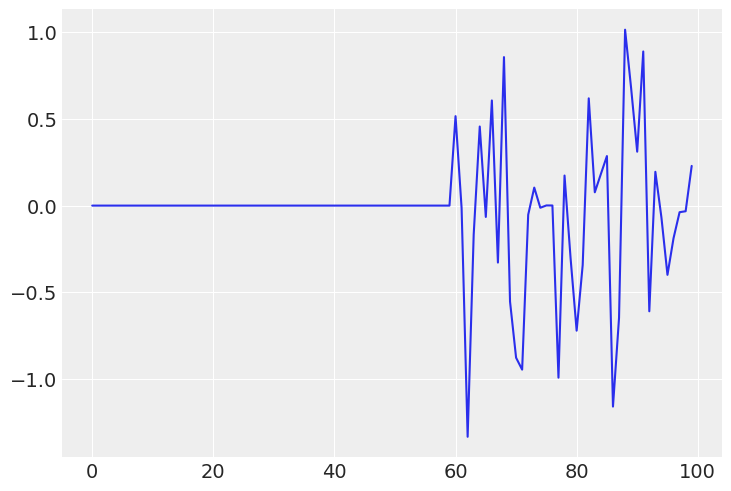

In [230]:
plt.plot(y_train - y_out)

## Training

In [87]:
def my_model(y):
    T = len(y)
        
    noise = numpyro.sample("noise", dist.HalfNormal(1))
    _mu = numpyro.sample("mu", dist.Normal(0, 1))
    a = numpyro.sample("a", dist.Normal(0, 1))
    w = numpyro.sample("w", dist.Cauchy(10, 1))
    phi = numpyro.sample("phi", dist.Beta(1, 1))
    
    t = jnp.arange(0, len(y))
    mu = _mu + a*jnp.sin(w*t + 3.14*phi)
    
    y_hat = numpyro.sample('y_hat', dist.Normal(mu, noise), obs=y)


In [88]:
model = my_model
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=200, num_samples=500, num_chains=2)
mcmc.run(jax.random.PRNGKey(0), y_train)
mcmc.print_summary()
samples = mcmc.get_samples()

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.23      0.18      0.28     -0.09      0.48      7.00      1.43
        mu      0.19      0.06      0.18      0.07      0.28    427.13      1.00
     noise      0.60      0.05      0.60      0.53      0.69     52.25      1.04
       phi      0.58      0.23      0.61      0.27      1.00      6.67      1.11
         w      5.05      3.83      2.72      1.60     10.64      1.18      3.72

Number of divergences: 7


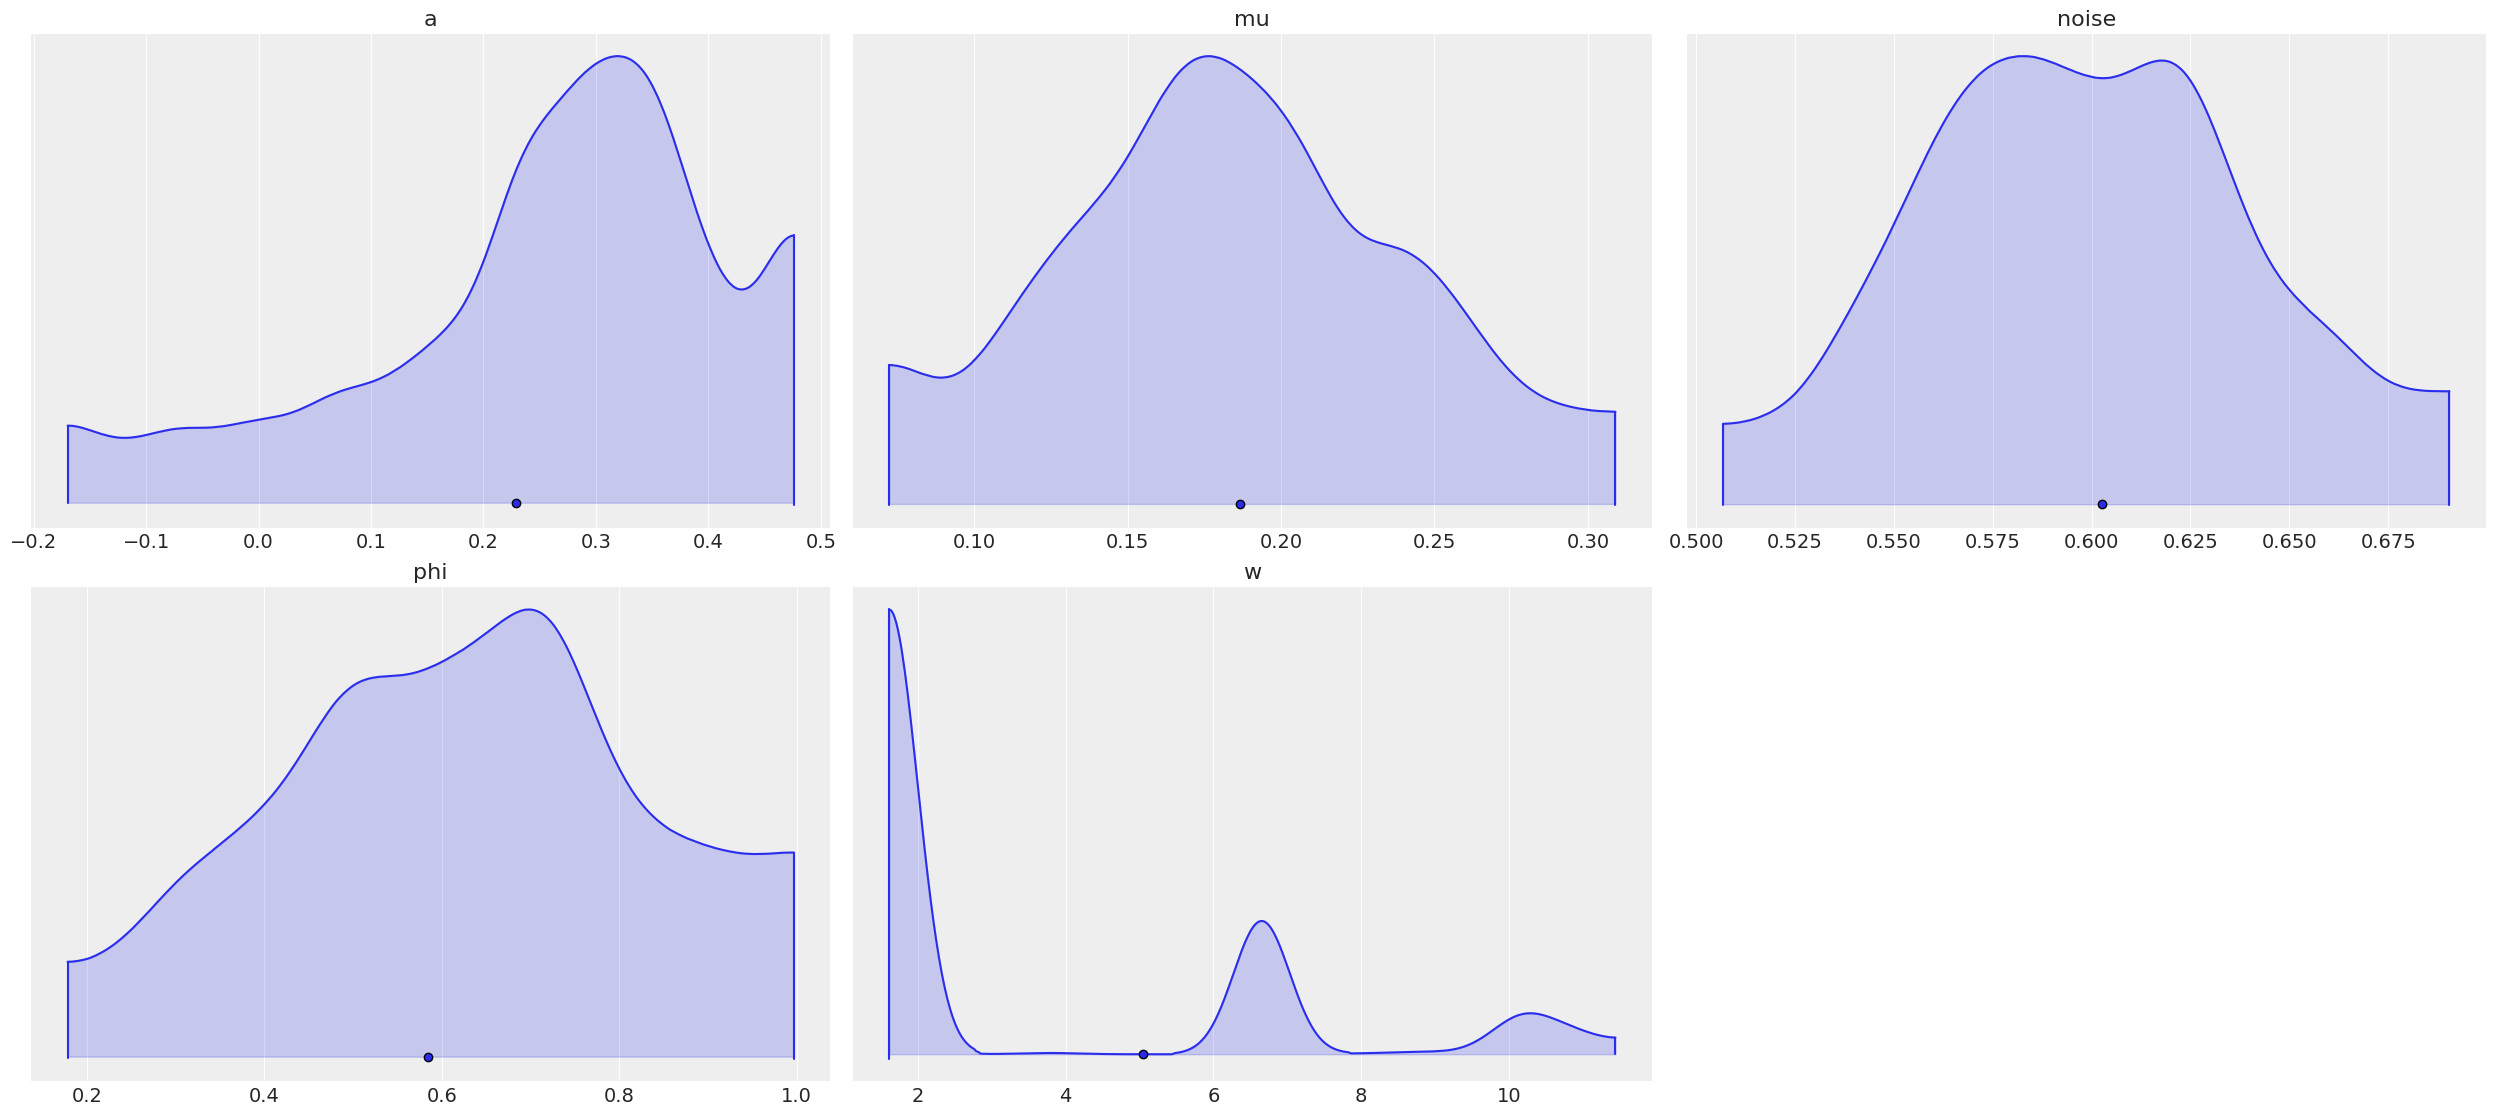

In [89]:
my_post = az.from_numpyro(posterior=mcmc)

az.plot_density(
    [my_post],
    shade=0.2,
)
plt.show()